### Purpose of this notebook: Develop algorithms to procedurally generate block construction targets 

* blockworld is 8x8 grid
* allowable blocks are: 1x1, 2x2, 4x4 squares and the triangles that comprise them
* target difficulty roughly varies according to shape and number of holes
* constraints on construction include: 
    * physical stability (a tipped over triangle will fall!)
    * geometry (presence & shape of "holes")
    * inventory (not infinite number of large 8x2 blocks!)
    * cost (# blocks)

In [4]:
from __future__ import division

import numpy as np
import os, sys
from PIL import Image

from matplotlib import pylab, mlab, pyplot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.path import Path
import matplotlib.patches as patches
%matplotlib inline

from IPython.core.pylabtools import figsize, getfigs

import seaborn as sns

import random

from scipy.stats import norm
from IPython.display import clear_output

import copy
import importlib

### Add Paths

## root paths
curr_dir = os.getcwd()
proj_dir = os.path.abspath(os.path.join(curr_dir,'..','..')) ## use relative paths

## add helpers to python path
import sys
if os.path.join(proj_dir, 'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir, 'stimuli'))

## custom helper modules
import separation_axis_theorem as sat
import blockworld_helpers as utils

def cls():
    os.system('cls' if os.name=='nt' else 'clear')


### start with simple cases 

#### define inventory of block types, positioned at origin

In [ ]:
## sketch of blocklaying procedure:

## sample block size and place in leftmost, lowest position that you can and place in the array

## make sure that no blocks collide

## keep going until the summed area of all blocks equals or exceeds the total area of the arena

## fill these crevices

In [ ]:
importlib.reload(utils)
b1 = utils.Block(1,1)
b2 = utils.Block(2,2)
b3 = utils.Block(4,2)

In [ ]:
importlib.reload(utils)

def patch_for_block(b):
    return utils.get_patch(b.base_block.translate(b.base_block.verts,b.x,b.y),color=b.base_block.color)

def patches_for_floor(floor_blocks, xs):
    patches = []
    for (i, b) in enumerate(floor_blocks):
        patches.append(patch_for_block_here(b,xs[i],0))
    return patches

def drawFloor(floor_blocks, xs):
    utils.render_blockworld(patches_for_floor(floor_blocks, xs))
    
def patches_for_world(blocks):
    patches = []
    for (b) in blocks:
        patches.append(patch_for_block(b))
    return patches

def drawWorld(world):
    utils.render_blockworld(patches_for_world(world.blocks))

# World Class
class World:
    
    width = 8
    height = 8

    block_dims = [
        (1,1),
        (1,2),
        (2,1),
        (2,2),
        (2,4),
        (4,2),
        (4,4),
        (8,2)
        ]
    
    block_colors = [
        '#D33E43',
        '#29335C',
        '#EAEAEA',
        '#0F8B8D',
        '#2E3B44',
        '#E79598',
        '#8A8FA6',
        '#91CACB',
        '#B3B7BB',
        '#D33E43',
        '#EAEAEA'
    ]

    base_blocks = [utils.BlockType(w,h,color=c) for ((w,h),c) in list(zip(sorted(block_dims),block_colors[0:len(block_dims)]))] # Block types should be in order from left to right, thinest to thickest, shortest to tallest
    block_widths = list(map(lambda b: b.width, base_blocks))
    
    def __init__(self):
        
        # Actual blocks present in world
        
        self.block_map = np.zeros((World.width, World.height), dtype=int) #bitmap for placement of blocks
        
        self.blocks = []
        
        self.full = False
        
    def check_full(self):
        '''
        Checks to see whether the World contains any empty space by summing block_map
        '''
        if not self.full:
            isFull = (sum(sum(self.block_map)) == width*height)
            self.full = isFull
            return isFull
        else:
            return True
      
    def fill_floor(self, floor_space):
        '''
        Fills a 'floor', a level horizontal surface, with blocks.
        Input: Lexicon of blocks- np arrays with 5 coordinates; length of available floor space
        Output: List of blocks that can be used to fill the floor space with no gaps
        '''
        
        floor_blocks = []
        floor_block_widths = []
        viable_block_widths = copy.deepcopy(self.block_widths)
        remaining_space = floor_space
        while remaining_space > 0:
            i = np.random.randint(0,len(viable_block_widths))
            if self.block_widths[i] <= remaining_space:
                floor_blocks.append([self.base_blocks[i],floor_space-remaining_space])
                floor_block_widths.append(self.block_widths[i])
                remaining_space -= self.block_widths[i]
            else:
                viable_block_widths.pop()
        return(floor_blocks)

    def fill_floor_here(self, lvl, left, right):
        '''
        Fills a 'floor', a level horizontal surface, with blocks.
        Input: Lexicon of blocks- np arrays with 5 coordinates; length of available floor space
        Output: List of blocks that can be used to fill the floor space with no gaps
        '''
        
        floor_space = right-left
        floor_blocks = []
        floor_block_x_location = left
        
        viable_block_widths = copy.deepcopy(self.block_widths)
        viable_blocks = copy.deepcopy(self.base_blocks)
        
        remaining_height = World.height - lvl
        remaining_space = floor_space
        
        while remaining_space > 0:
            i = np.random.randint(0,len(viable_blocks))
            base_block = self.base_blocks[i]
            if base_block.width <= remaining_space and base_block.height <= remaining_height: 
                b = utils.Block(self.base_blocks[i],floor_block_x_location,lvl)
                floor_block_x_location += b.width
                floor_blocks.append(b)
                self.blocks.append(b)
                remaining_space -= b.width
            else:
                viable_blocks.pop()
        self._update_map_with_floor_blocks(floor_blocks)

    def _update_map_with_floor_blocks(self, floor_blocks):
        for (i, b) in enumerate(floor_blocks):
            self.block_map[self.height-(b.y+b.height): self.height-b.y, b.x:(b.x+b.width)] = 1  
            #self.block_map[self.height-(lvl+b.height): self.height-lvl, floor_block_xs[i]:floor_block_xs[i+1]] = 1  
        #print(self.block_map)
    
    def fill_world(self):
        '''
        Semi-randomly fills world with blocks, adding a 'floor' of blocks to the next available flat surface 
        '''
        lvl = 0 #Start at bottom and work up
        while lvl <= World.height - 1: # Until at top
            #find floor
            while self.block_map[World.height - lvl - 1].all() and lvl < World.height: # check if level is full or reached top
                lvl += 1
            if lvl == World.height:
                    break
            left = 0
            while self.block_map[World.height - lvl - 1][left] == 1:
                left += 1
            right = left
            while right < World.width and self.block_map[World.height - lvl - 1][right] == 0:
                right += 1
            #print('fill_world_here: ' + str((lvl, left, right)))
            self.fill_floor_here(lvl, left, right)
        
        drawWorld(self)
    
    

In [ ]:
importlib.reload(utils)
w = utils.World()
w.fill_world(render=True)

In [ ]:
importlib.reload(utils)
w = utils.World()
w.add_block(4,2,1,4)
w.add_block(2,4,2,0)
utils.draw_world(w)

In [ ]:
# successively 'Jenga' blocks
importlib.reload(utils)
w = utils.World()
w.fill_world()
world_stages = [w]
# loop

# try removing blocks until one removed or no blocks left

utils.draw_world(w)
for j in range(0,5):
    i = 0;
    block_removed = False
    while not block_removed:
        #block_number = random_block_order.pop
        (block_removed, w2) = w.jenga_block(i)
        if block_removed:
            world_stages.append(w2)
            w = w2
            utils.draw_world(w)
        else:
            i += 1;


In [ ]:
importlib.reload(utils)
w = utils.World()
w.fill_world()
json_obj = w.save_to_json()
json_obj

In [ ]:
w2 = utils.World()
w2.populate_from_json(json_obj)
utils.draw_world(w2)
utils.draw_world(w)

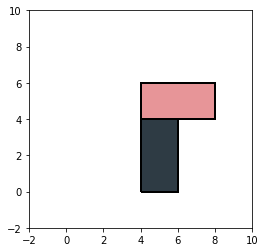


 a above b:  True 
 a below b:  False 
 a left b:  False 
 a right b:  False

 b above a:  False 
 b below a:  True 
 b left a:  False 
 b right a:  False

 a touching b:  True 
 b touching a:  True

 a abs_overlap b (horizontal):  2 
 b abs_overlap a (horizontal):  2 
 a abs_overlap b (vertical):  0 
 b abs_overlap a (vertical):  0

 a partially supported by b:  True 
 b partially supported by a:  False

 a completely supported by b:  False 
 b completely supported by a:  False


In [5]:
importlib.reload(utils)
w = utils.World()
a = w.add_block(4,2,4,4)
b = w.add_block(2,4,4,0)
utils.draw_world(w)
print('\n',
    'a above b: ', a.above(b), '\n', 
    'a below b: ', a.below(b), '\n', 
    'a left b: ', a.leftof(b), '\n', 
    'a right b: ', a.rightof(b)
)

print('\n',
    'b above a: ', b.above(a), '\n', 
    'b below a: ', b.below(a), '\n', 
    'b left a: ', b.leftof(a), '\n', 
    'b right a: ', b.rightof(a)
)

print('\n',
    'a touching b: ', a.touching(b), '\n',
    'b touching a: ', b.touching(a))

print('\n',
    'a abs_overlap b (horizontal): ', a.abs_overlap(b), '\n',
    'b abs_overlap a (horizontal): ', b.abs_overlap(a), '\n',
    'a abs_overlap b (vertical): ', a.abs_overlap(b, horizontal_overlap=False), '\n',
    'b abs_overlap a (vertical): ', b.abs_overlap(a, horizontal_overlap=False))


print('\n',
    'a partially supported by b: ', a.partially_supported_by(b), '\n',
    'b partially supported by a: ', b.partially_supported_by(a))

print('\n',
    'a completely supported by b: ', a.completely_supported_by(b), '\n',
    'b completely supported by a: ', b.completely_supported_by(a))

In [ ]:
help(utils.Block.above)

In [ ]:
importlib.reload(utils)
w2 = utils.World()
w2.add_block(1,2,2,0)
w2.add_block(2,2,2,2)
w2.add_block(2,2,4,0)
w2.add_block(2,2,4,2)
w2.add_block(1,2,7,0)
w2.add_block(1,2,7,2)
w2.add_block(4,2,4,4)
w2.add_block(4,2,4,6)
w2.add_block(2,1,2,4)
w2.add_block(2,1,2,5)
utils.draw_world(w2)

In [ ]:
importlib.reload(utils)
w2 = utils.World()
w2.add_block(1,2,2,0)
w2.add_block(1,2,2,2)
w2.add_block(2,2,2,4)
w2.add_block(2,4,4,0)
w2.add_block(2,4,4,4)
utils.draw_world(w2)